# MadMiner particle physics tutorial

# Part 3: Training a likelihood ratio estimator

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In part 3 of this tutorial we will finally train a neural network to estimate likelihood ratios. We assume that you have run part 1 and 2a of this tutorial. If, instead of 2a, you have run part 2b, you just have to load a different filename later.

## Preparations

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.sampling import SampleAugmenter
from madminer import sampling
from madminer.ml import ParameterizedRatioEstimator
from madminer.plotting import plot_2d_morphing_basis, plot_distributions
from madminer.limits import AsymptoticLimits


In [2]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. Make (unweighted) training and test samples with augmented data

At this point, we have all the information we need from the simulations. But the data is not quite ready to be used for machine learning. The `madminer.sampling` class `SampleAugmenter` will take care of the remaining book-keeping steps before we can train our estimators:

First, it unweights the samples, i.e. for a given parameter vector `theta` (or a distribution `p(theta)`) it picks events `x` such that their distribution follows `p(x|theta)`. The selected samples will all come from the event file we have so far, but their frequency is changed -- some events will appear multiple times, some will disappear.

Second, `SampleAugmenter` calculates all the augmented data ("gold") that is the key to our new inference methods. Depending on the specific technique, these are the joint likelihood ratio and / or the joint score. It saves all these pieces of information for the selected events in a set of numpy files that can easily be used in any machine learning framework.

In [4]:
sampler = SampleAugmenter('data/lhe_data_shuffled.h5')
# sampler = SampleAugmenter('data/delphes_data_shuffled.h5')

15:32 madminer.analysis    INFO    Loading data from data/madminer_example_shuffled.h5
15:32 madminer.analysis    INFO    Found 2 parameters
15:32 madminer.analysis    INFO    Did not find nuisance parameters
15:32 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
15:32 madminer.analysis    INFO    Found 2 observables
15:32 madminer.analysis    INFO    Found 6537 events
15:32 madminer.analysis    INFO    Found morphing setup with 6 components


The `SampleAugmenter` class defines five different high-level functions to generate train or test samples:
- `sample_train_plain()`, which only saves observations x, for instance for histograms or ABC;
- `sample_train_local()` for methods like SALLY and SALLINO, which will be demonstrated in the second part of the tutorial;
- `sample_train_density()` for neural density estimation techniques like MAF or SCANDAL;
- `sample_train_ratio()` for techniques like CARL, ROLR, CASCAL, and RASCAL, when only theta0 is parameterized;
- `sample_train_more_ratios()` for the same techniques, but with both theta0 and theta1 parameterized;
- `sample_test()` for the evaluation of any method.

For the arguments `theta`, `theta0`, or `theta1`, you can (and should!) use the helper functions `benchmark()`, `benchmarks()`, `morphing_point()`, `morphing_points()`, and `random_morphing_points()`, all defined in the `madminer.sampling` module.

Here we'll train a likelihood ratio estimator with the ALICES method, so we focus on the `extract_samples_train_ratio()` function.

In [5]:
x, theta0, theta1, y, r_xz, t_xz, _ = sampler.sample_train_ratio(
    theta0=sampling.random_morphing_points(100, [('gaussian', 0., 15.), ('gaussian', 0., 15.)]),
    theta1=sampling.benchmark('sm'),
    n_samples=100000,
    folder='./data/samples',
    filename='train'
)

15:32 madminer.sampling    INFO    Extracting training sample for ratio-based methods. Numerator hypothesis: ('random_morphing_points', (100, [('gaussian', 0.0, 15.0), ('gaussian', 0.0, 15.0)])), denominator hypothesis: ('benchmark', 'sm')
/Users/johannbrehmer/work/projects/madminer/madminer/madminer/analysis.py:284: RuntimeWarning: invalid value encountered in sqrt
  xsec_uncertainties = xsec_uncertainties ** 0.5
15:32 madminer.sampling    WARNING Large statistical uncertainty on the total cross section when sampling from theta = [4.59589697 7.76994673]: (0.000720 +/- 0.000073) pb (10.124460729467307 %). Skipping these warnings in the future...
15:32 madminer.sampling    INFO    Effective number of samples: mean 16.457179431399243, with individual thetas ranging from 7.197251196742754 to 68.10093524160831
15:32 madminer.sampling    INFO    Effective number of samples: mean 5230.0, with individual thetas ranging from 5230.0 to 5230.0


For the evaluation we'll need a test sample:

In [6]:
_ = sampler.sample_test(
    theta=sampling.benchmark('sm'),
    n_samples=1000,
    folder='./data/samples',
    filename='test'
)

15:32 madminer.sampling    INFO    Extracting evaluation sample. Sampling according to ('benchmark', 'sm')
15:32 madminer.sampling    INFO    Effective number of samples: 1306.0000000000002


## 2. Plot cross section over parameter space

This is not strictly necessary, but we can also plot the cross section as a function of parameter space:

In [8]:
thetas_benchmarks, xsecs_benchmarks, xsec_errors_benchmarks = sampler.cross_sections(
    theta=sampling.benchmarks(['sm', 'w', 'morphing_basis_vector_2', 'morphing_basis_vector_3', 'morphing_basis_vector_4', 'morphing_basis_vector_5'])
)

thetas_morphing, xsecs_morphing, xsec_errors_morphing = sampler.cross_sections(
    theta=sampling.random_morphing_points(1000, [('gaussian', 0., 4.), ('gaussian', 0., 4.)])
)

15:32 madminer.sampling    INFO    Starting cross-section calculation
15:32 madminer.sampling    INFO    Starting cross-section calculation


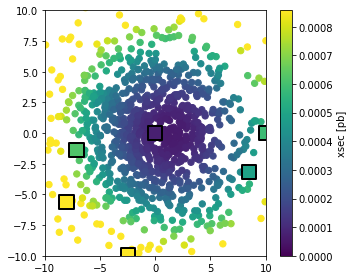

In [9]:
cmin, cmax = 0., 2.5 * np.mean(xsecs_morphing)

fig = plt.figure(figsize=(5,4))

sc = plt.scatter(thetas_morphing[:,0], thetas_morphing[:,1], c=xsecs_morphing,
            s=40., cmap='viridis', vmin=cmin, vmax=cmax,
            marker='o')

plt.scatter(thetas_benchmarks[:,0], thetas_benchmarks[:,1], c=xsecs_benchmarks,
            s=200., cmap='viridis', vmin=cmin, vmax=cmax, lw=2., edgecolor='black',
            marker='s')

cb = plt.colorbar(sc)
cb.set_label('xsec [pb]')

plt.xlim(-10.,10.)
plt.ylim(-10.,10.)
plt.tight_layout()
plt.show()

What  you see here is a morphing algorithm in action. We only asked MadGraph to calculate event weights (differential cross sections, or basically squared matrix elements) at six fixed parameter points (shown here as squares with black edges). But with our knowledge about the structure of the process we can interpolate any observable to any parameter point without loss (except that statistical uncertainties might increase)!

## 3. Train likelihood ratio estimator

It's now time to build the neural network that estimates the likelihood ratio. The central object for this is the `madminer.ml.ParameterizedRatioEstimator` class. It defines functions that train, save, load, and evaluate the estimators.

In the initialization, the keywords `n_hidden` and `activation` define the architecture of the (fully connected) neural network:

In [10]:
estimator = ParameterizedRatioEstimator(
    n_hidden=(100,),
    activation="tanh"
)

To train this model we will minimize the ALICES loss function described in ["Likelihood-free inference with an improved cross-entropy estimator"](https://arxiv.org/abs/1808.00973). Many alternatives, including RASCAL, are described in ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013) and ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020). There is also SCANDAL introduced in ["Mining gold from implicit models to improve likelihood-free inference"](https://arxiv.org/abs/1805.12244).

In [11]:
estimator.train(
    method='alices',
    theta='data/samples/theta0_train.npy',
    x='data/samples/x_train.npy',
    y='data/samples/y_train.npy',
    r_xz='data/samples/r_xz_train.npy',
    t_xz='data/samples/t_xz_train.npy',
    alpha=1.,
    n_epochs=20,
)

estimator.save('models/alices')

15:32 madminer.ml          INFO    Starting training
15:32 madminer.ml          INFO      Method:                 alices
15:32 madminer.ml          INFO      alpha:                  1.0
15:32 madminer.ml          INFO      Batch size:             200
15:32 madminer.ml          INFO      Optimizer:              amsgrad
15:32 madminer.ml          INFO      Epochs:                 20
15:32 madminer.ml          INFO      Learning rate:          0.001 initially, decaying to 0.0001
15:32 madminer.ml          INFO      Validation split:       0.25
15:32 madminer.ml          INFO      Early stopping:         True
15:32 madminer.ml          INFO      Scale inputs:           True
15:32 madminer.ml          INFO      Shuffle labels          False
15:32 madminer.ml          INFO      Samples:                all
15:32 madminer.ml          INFO    Loading training data
15:32 madminer.ml          INFO    Found 100000 samples with 2 parameters and 2 observables
15:32 madminer.ml          INFO    Resca

## 4. Evaluate likelihood ratio estimator

`estimator.evaluate_log_likelihood_ratio(theta,x)` estimated the log likelihood ratio and the score for all combination between the given phase-space points `x` and parameters `theta`. That is, if given 100 events `x` and a grid of 25 `theta` points, it will return 25\*100 estimates for the log likelihood ratio and 25\*100 estimates for the score, both indexed by `[i_theta,i_x]`.

In [12]:
theta_each = np.linspace(-20.,20.,21)
theta0, theta1 = np.meshgrid(theta_each, theta_each)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T
np.save('data/samples/theta_grid.npy', theta_grid)

theta_denom = np.array([[0.,0.]])
np.save('data/samples/theta_ref.npy', theta_denom)


In [13]:
estimator.load('models/alices')

log_r_hat, _ = estimator.evaluate_log_likelihood_ratio(
    theta='data/samples/theta_grid.npy',
    x='data/samples/x_test.npy',
    evaluate_score=False
)

Let's look at the result:

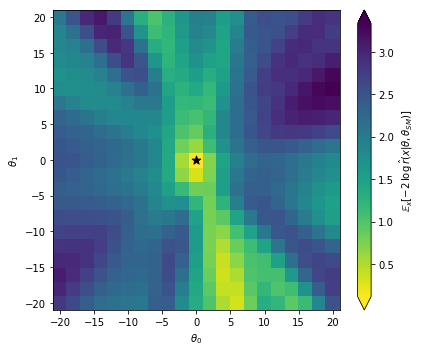

In [14]:
bin_size = theta_each[1] - theta_each[0]
edges = np.linspace(theta_each[0] - bin_size/2, theta_each[-1] + bin_size/2, len(theta_each)+1)

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

expected_llr = np.mean(log_r_hat,axis=1)
best_fit = theta_grid[np.argmin(-2.*expected_llr)]

cmin, cmax = np.min(-2*expected_llr), np.max(-2*expected_llr)
    
pcm = ax.pcolormesh(edges, edges, -2. * expected_llr.reshape((21,21)),
                    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
                    cmap='viridis_r')
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.scatter(best_fit[0], best_fit[1], s=80., color='black', marker='*')

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label(r'$\mathbb{E}_x [ -2\, \log \,\hat{r}(x | \theta, \theta_{SM}) ]$')

plt.tight_layout()
plt.show()


Note that in this tutorial our sample size was very small, and the network might not really have a chance to converge to the correct likelihood ratio function. So don't worry if you find a minimum that is not at the right point (the SM, i.e. the origin in this plot). Feel free to dial up the event numbers in the run card as well as the training samples and see what happens then!

## 4. Statistical analysis

In the end, what we care about are not plots of the log likelihood ratio, but limits on parameters. But at least under some asymptotic assumptions, these are directly related. MadMiner makes it easy to calculate p-values in the asymptotic limit with the `AsymptoticLimits` class in the `madminer.limits`: 

In [15]:
limits = AsymptoticLimits('data/madminer_example_shuffled.h5')

15:39 madminer.analysis    INFO    Loading data from data/madminer_example_shuffled.h5
15:39 madminer.analysis    INFO    Found 2 parameters
15:39 madminer.analysis    INFO    Did not find nuisance parameters
15:39 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
15:39 madminer.analysis    INFO    Found 2 observables
15:39 madminer.analysis    INFO    Found 6537 events
15:39 madminer.analysis    INFO    Found morphing setup with 6 components


This class provids two high-level functions:
- `AsymptoticLimits.observed_limits()` lets us calculate p-values on a parameter grid for some observed events, and
- `AsymptoticLimits.expected_limits()` lets us calculate expected p-values on a parameter grid based on all data in the MadMiner file.

Note that these limits include both rate and kinematic information (the neural network is used for the kinematic part).

Let's try both:

In [16]:
theta_min, theta_max = -20., 20.
resolution = 25

### Expected limits

First, with `mode="rate"`, we can calculate expected limits based only on rate information:

In [17]:
_, p_values_expected_xsec, best_fit_expected_xsec = limits.expected_limits(
    theta_true=[0.,0.],
    theta_ranges=[(theta_min, theta_max), (theta_min, theta_max)],
    mode="rate",
    resolution=resolution,
    luminosity=300000.0
)

TypeError: expected_limits() got an unexpected keyword argument 'resolution'

`mode="histo"` calculates limits based on histograms. For now, there is not a lot of freedom in this step, the histogram binning is determined automatically.

In [ ]:
_, p_values_expected_histo, best_fit_expected_histo = limits.expected_limits(
    theta_true=[0.,0.],
    theta_ranges=[(theta_min, theta_max), (theta_min, theta_max)],
    mode="histo",
    hist_vars=["pt_j1"],
    include_xsec=False,
    resolution=resolution,
    luminosity=300000.0
)

Finally and perhaps most importantly, `mode="ml"` allows us to calculate limits based on any `ParamterizedRatioEstimator` instance like the ALICES estimator trained above:

In [ ]:
theta_grid, p_values_expected_ml, best_fit_expected_ml = limits.expected_limits(
    theta_true=[0.,0.],
    theta_ranges=[(theta_min, theta_max), (theta_min, theta_max)],
    mode="ml",
    model_file='models/alices',
    include_xsec=False,
    resolution=resolution,
    luminosity=300000.0
)

### Observed limits

Observed limits take as input actual data, which we here generate on the fly:

In [ ]:
sampler = SampleAugmenter('data/madminer_example_shuffled.h5')
x_observed, _ = sampler.extract_samples_test(
    theta=sampling.morphing_point([0.,0.]),
    n_samples=5,
    folder=None,
    filename=None
)

In [ ]:
_, p_values_observed, best_fit_observed = limits.observed_limits(
    x_observed=x_observed,
    theta_ranges=[(theta_min, theta_max), (theta_min, theta_max)],
    mode="ml",
    model_file='models/alices',
    include_xsec=True,
    resolution=resolution,
    luminosity=300000.0,
)

### Plot

Let's plot the results:

In [ ]:
bin_size = (theta_max - theta_min)/(resolution - 1)
edges = np.linspace(theta_min - bin_size/2, theta_max + bin_size/2, resolution + 1)
centers = np.linspace(theta_min, theta_max, resolution)

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

cmin, cmax = 1.e-3, 1.
    
pcm = ax.pcolormesh(
    edges, edges, p_values_expected_ml.reshape((resolution, resolution)),
    norm=matplotlib.colors.LogNorm(vmin=cmin, vmax=cmax),
    cmap='Greys_r'
)
cbar = fig.colorbar(pcm, ax=ax, extend='both')

plt.contour(
    centers, centers, p_values_expected_xsec.reshape((resolution, resolution)),
    levels=[0.05],
    linestyles='-', colors='darkgreen'
)
plt.contour(
    centers, centers, p_values_expected_ml.reshape((resolution, resolution)),
    levels=[0.05],
    linestyles='-', colors='#CC002E'
)
plt.contour(
    centers, centers, p_values_expected_histo.reshape((resolution, resolution)),
    levels=[0.05],
    linestyles='-', colors='C1'
)
plt.contour(
    centers, centers, p_values_observed.reshape((resolution, resolution)),
    levels=[0.05],
    linestyles='--', colors='black'
)

plt.scatter(
    theta_grid[best_fit_expected_xsec][0], theta_grid[best_fit_expected_xsec][1],
    s=80., color='darkgreen', marker='*',
    label="xsec"
)
plt.scatter(
    theta_grid[best_fit_expected_ml][0], theta_grid[best_fit_expected_ml][1],
    s=80., color='#CC002E', marker='*',
    label="ALICES"
)
plt.scatter(
    theta_grid[best_fit_expected_histo][0], theta_grid[best_fit_expected_histo][1],
    s=80., color='C1', marker='*',
    label="Histo"
)
plt.scatter(
    theta_grid[best_fit_observed][0], theta_grid[best_fit_observed][1],
    s=80., color='black', marker='*',
    label="Observed"
)

plt.legend()

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label('Expected p-value (ALICES)')

plt.tight_layout()
plt.show()


That's it for now. Please have a look at the documentation for a detailed description of all classes and functions. And if you're curious about SALLY, Fisher information matrices, and ensemble methods, please look at the second part of the tutorial!